#**Importando os dados:**

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')


In [120]:
df = pd.read_csv('autos.csv', encoding = 'ISO-8859-1')

In [55]:
df

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371523,2016-03-14 17:48:27,Suche_t4___vito_ab_6_sitze,privat,Angebot,2200,test,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
371524,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,privat,Angebot,1199,test,cabrio,2000,automatik,101,fortwo,125000,3,benzin,smart,nein,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
371525,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,privat,Angebot,9200,test,bus,1996,manuell,102,transporter,150000,3,diesel,volkswagen,nein,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
371526,2016-03-20 19:41:08,VW_Golf_Kombi_1_9l_TDI,privat,Angebot,3400,test,kombi,2002,manuell,100,golf,150000,6,diesel,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

**Retirei algumas outliers, pois alguns dados estão desconexos, exemplo, veículos de 11 milhões de Euros, 99 milhões de Euros, preço abaixo dos 10 Euros, etc.**

In [121]:
df = df[df["price"] > 10]
df = df[df["price"]< 30000]

In [122]:
df = df.sample(10000)

**Vamos retirar algumas Features, algumas delas contém 2 tipos de amostras, sendo que um dos tipos só tem 3 amostra, não será válido, por exemplo, a "seller" é dividida em privada e comercial, só existe 3 amostras como comercial. e 371.525 privadas.**

In [123]:
df.drop(columns=["name", "seller", "offerType", "nrOfPictures", "dateCreated", "postalCode"], inplace=True)

In [124]:
df

,dateCrawled,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,lastSeen
334824,2016-03-26 17:51:14,2290,control,kleinwagen,2007,manuell,54,fox,150000,4,benzin,volkswagen,nein,2016-04-06 06:46:06
10135,2016-03-20 11:48:28,4790,test,kleinwagen,2004,manuell,116,cooper,150000,8,benzin,mini,nein,2016-04-06 10:15:31
53115,2016-04-02 13:40:51,1450,test,kombi,1999,automatik,0,galant,150000,4,benzin,mitsubishi,NaN,2016-04-06 11:45:01
141371,2016-03-05 16:50:26,5750,control,NaN,2017,manuell,105,golf,150000,2,diesel,volkswagen,nein,2016-03-09 18:46:58
74316,2016-03-28 21:53:07,3000,control,kleinwagen,2008,automatik,0,clio,100000,0,benzin,renault,ja,2016-03-28 21:53:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91802,2016-03-30 22:37:39,1950,control,NaN,2016,manuell,0,polo,150000,1,benzin,volkswagen,NaN,2016-04-05 15:46:33
190564,2016-03-22 14:45:30,250,control,limousine,1997,automatik,0,vectra,150000,0,NaN,opel,ja,2016-03-22 14:45:30
279369,2016-03-16 07:51:36,1600,test,kleinwagen,2002,manuell,65,corsa,150000,6,diesel,opel,nein,2016-04-07 08:15:49
21441,2016-03-11 14:38:55,2500,control,bus,2005,manuell,114,andere,150000,5,diesel,opel,nein,2016-03-11 14:38:55


In [152]:
df.isna().sum()

dateCrawled               0
price                     0
abtest                    0
vehicleType             911
yearOfRegistration        0
gearbox                 494
powerPS                   0
model                   494
kilometer                 0
monthOfRegistration       0
fuelType                823
brand                     0
notRepairedDamage      1847
lastSeen                  0
dtype: int64

#**XGBOOST**

In [125]:
#Separando o que é features e target:
X = df.drop(columns="price")
y = df["price"]

# Dividindo em dados de teste e dados de treino, peguei 20% para dados de teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Iniciando a construção da Pipeline:
# ==========================================================
#Primeiro vamos tratar as features numéricas. Tratando os valores nulos (NaN) e escalonando já que a variância entre as features é grande.
pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                              ("std", StandardScaler())])

features_num = X_train.select_dtypes(include=np.number).columns.tolist()
# ==========================================================
# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos pelos dados mais constantes e posteriormente codificaremos todas elas com o One Hot Encoder e Ordinal Enconder. Percebemos que o One Hot Encoder 
# é para features categóricas binárias e o Ordinal Enconder para features categóricas ordinais (não binários)

pipe_features_oe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                             ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

features_oe = ["vehicleType", "model", "fuelType", "brand"]

# ==========================================================
# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos pelos dados por "unknown" e posteriormente codificaremos todas elas com o One Hot Encoder.

pipe_features_ohe = Pipeline([("input_cat_ohe", SimpleImputer(strategy="constant", fill_value="unknown")),
                            ("OneHot", OneHotEncoder(handle_unknown='ignore'))])

features_ohe = ["abtest", "gearbox", "notRepairedDamage"]

# ==========================================================
# Pré-processador => Pegando as pipelines anteriores e unindo-as.
pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                     ("transf_cat_oe", pipe_features_oe, features_oe),
                                     ("transf_cat_ohe", pipe_features_ohe, features_ohe)])

# ==========================================================
# Pipeline final, usando o pré-processador e o estimador que queremos utilizar, neste caso o XGBoost para regressão.
pipe_xgbr = Pipeline([("pre_processador", pre_processador),
                     ("xgbr", XGBRegressor(eval_metric='logloss', random_state=42))])

# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = KFold(n_splits=5, random_state=42, shuffle=True)

#Montando a grade de parâmetros do estimador (XGBoost)
params_grid_xgbr = {"xgbr__n_estimators": [1000, 5000, 10000],
                   "xgbr__max_depth": [2, 3, 8, 10],
                   "xgbr__learning_rate": [0.1, 0.01, 0.001],
                   "xgbr__colsample_bytree": [0.5],
                   "xgbr__subsample": [0.5]}


#Motando a grade geral de parâmetros.
auto_grid_xgbr = GridSearchCV(estimator=pipe_xgbr,
                       param_grid=params_grid_xgbr,
                       scoring="r2",
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

auto_grid_xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[20:45:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processador',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['yearOfRegistration',
                                                                          'powerPS',
                                                                          'kilometer',
                                                                          'monthOfRegistration']),
  

In [87]:
auto_grid_xgbr.best_params_

{'xgbr__colsample_bytree': 0.5,
 'xgbr__learning_rate': 0.001,
 'xgbr__max_depth': 5,
 'xgbr__n_estimators': 5000,
 'xgbr__subsample': 0.5}

In [ ]:
xgbr_results = pd.DataFrame(auto_grid_xgbr.cv_results_)
xgbr_results.sort_values(by=["rank_test_score"])

In [126]:
# Predições de treino
y_pred_train_xgbr = auto_grid_xgbr.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train_xgbr):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_xgbr):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_xgbr)):.2f}")

# Predições de teste
y_pred_test_xgbr = auto_grid_xgbr.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test_xgbr):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_xgbr):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_xgbr)):.2f}") 


Métricas de treino:

R^2: 0.98
MAE: 549.56
RMSE: 805.30

Métricas de teste:

R^2: 0.85
MAE: 1318.65
RMSE: 2181.57


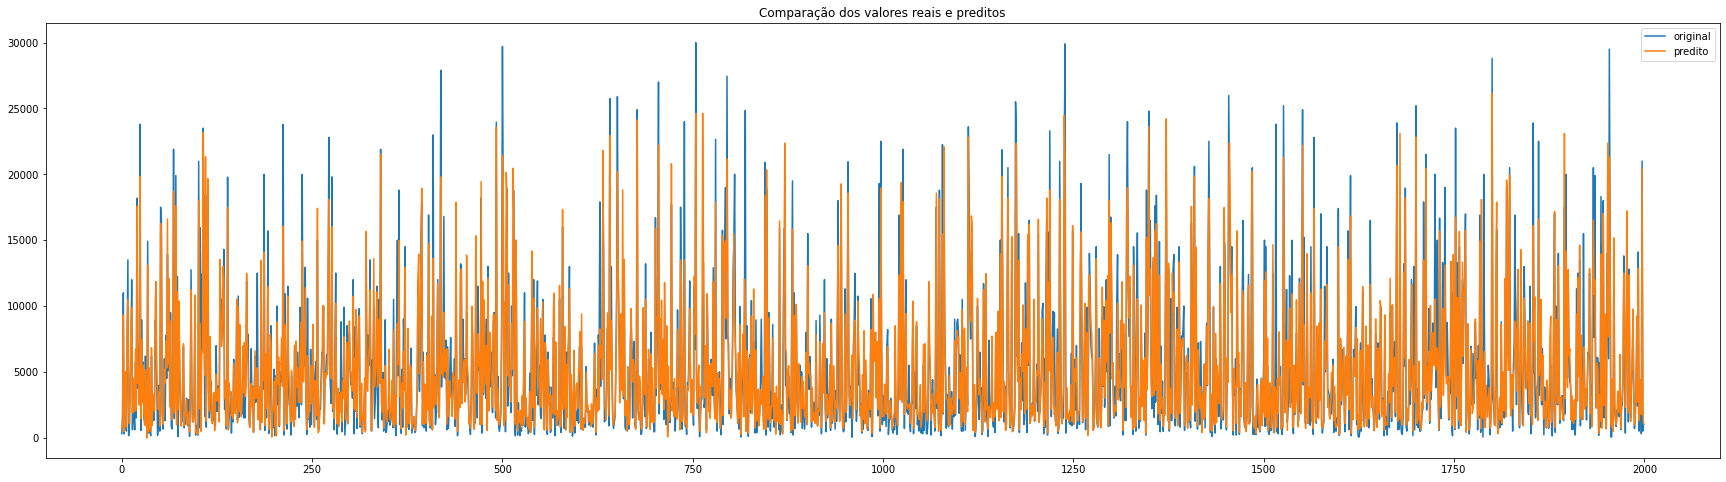

In [127]:
plt.figure(figsize=(30,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_test_xgbr, label="predito")
plt.title("Comparação dos valores reais e preditos")
plt.legend()
plt.show();

Salvado o estimador...

In [85]:
import pickle

In [128]:
with open("auto_grid_xgbr.pkl", "wb") as f:
    pickle.dump(auto_grid_xgbr, f)

In [86]:
with open("auto_grid_xgbr.pkl", "rb") as f:
    
    auto_grid_xgbr = pickle.load(f)

[19:54:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [129]:
y_pred_test_xgbr

array([  666.6399,   997.2858,  9302.802 , ..., 20447.01  ,  1944.2072,
        1061.5059], dtype=float32)

In [130]:
y_test.values

array([  299,  1650, 10998, ..., 21000,   500,   999])

**Vamos criar uma tabela com a porcentagem de acertos para cada dado**

In [131]:
tabela_xgbr = pd.DataFrame()

In [132]:
tabela_xgbr["valores reais"] = y_test

In [133]:
tabela_xgbr["valores preditos"] = y_pred_test_xgbr

In [134]:
tabela_xgbr["porcentagem de acerto %"]= (y_test/y_pred_test_xgbr)*100

In [135]:
lista_num = []
for c in tabela_xgbr["porcentagem de acerto %"]:
  if c > 100:
    num = abs(c - 200)
    lista_num.append(num)
  else:
    num = c
    lista_num.append(num)
  

tabela_xgbr["porcentagem de acerto %"]= lista_num

In [136]:
tabela_xgbr

,valores reais,valores preditos,porcentagem de acerto %
227024,299,666.639893,44.851801
235861,1650,997.285828,34.550943
59304,10998,9302.801758,81.777552
40096,300,468.644775,64.014370
192567,3750,5035.664551,74.468821
...,...,...,...
34380,4400,4405.408203,99.877237
73071,300,1755.465942,17.089480
354136,21000,20447.009766,97.295496
76638,500,1944.207153,25.717424


Salvando a tabela...

In [137]:
tabela_xgbr.to_csv("06-carros_usados_xgbr.csv")

#**Interpretando o modelo globalmente**

**Para a interpretação só podemos considerar as features numéricas, vamos retirar as features categóricas:**

Percebemos que as features que tem dados como números contínuos tem um maior impacto na interpretação do que as features com dados como números discretos e as features com os maiores valores pesam mais na saída final, se analisarmos no dataset veremos que os valores da feature 'rent amount' são maiores que 'hoa' e assim sucessivamente como vemos no gráfico final:

**SHAP**

In [ ]:
!pip install shap
import shap

**Agora vamos tratar o NaN nas Features categóricas**

In [ ]:
#"User_Score", "Publisher", "Rating"
ss = SimpleImputer(strategy="constant", fill_value="unknown")
ss.fit(df[["vehicleType", "gearbox", "model", "notRepairedDamage"]])

m = ss.transform(df[["vehicleType", "gearbox", "model", "notRepairedDamage"]])
df[["vehicleType", "gearbox", "model", "notRepairedDamage"]] = m

**O Shap só aceita dados numéricos, vamos transformar as Features categóricas em numéricas.**

**Transformando as Features categóricas em numéricas - OneHotEnconder - Features de dados binários:**

In [168]:
# "abtest"
ohe =  OneHotEncoder(handle_unknown='ignore')
ohe.fit(df[["abtest"]])

df["abtest"] = ohe.transform(df[["abtest"]]).toarray()

**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [170]:
# "dateCrawled", "vehicleType", "lastSeen", "brand", "model",  "fuelType", "notRepairedDamage", "gearbox"
oe =  OrdinalEncoder()
oe.fit(df[["dateCrawled", "vehicleType", "lastSeen", "brand", "model",  "fuelType", "notRepairedDamage", "gearbox"]])
df[["dateCrawled", "vehicleType", "lastSeen", "brand", "model",  "fuelType", "notRepairedDamage", "gearbox"]] = oe.transform(df[["dateCrawled", "vehicleType", "lastSeen", "brand", "model",  "fuelType", "notRepairedDamage", "gearbox"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [172]:
df.columns

Index(['dateCrawled', 'price', 'abtest', 'vehicleType', 'yearOfRegistration',
       'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration',
       'fuelType', 'brand', 'notRepairedDamage', 'lastSeen'],
      dtype='object')

In [173]:
ssc = StandardScaler()

ssc.fit(df[['dateCrawled','abtest', 'vehicleType', 'yearOfRegistration','gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration','fuelType', 'brand', 'notRepairedDamage', 'lastSeen']])
h= ssc.transform(df[['dateCrawled','abtest', 'vehicleType', 'yearOfRegistration','gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration','fuelType', 'brand', 'notRepairedDamage', 'lastSeen']])
df[['dateCrawled','abtest', 'vehicleType', 'yearOfRegistration','gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration','fuelType', 'brand', 'notRepairedDamage', 'lastSeen']] = h

In [175]:
df

,dateCrawled,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,lastSeen
334824,0.532332,2290,1.037087,-0.396942,0.036760,0.326232,-0.271415,0.006530,0.603178,-0.477248,-0.687138,1.274655,-0.167086,0.756968
10135,-0.207942,4790,-0.964239,-0.396942,-0.009674,0.326232,0.003921,-0.325958,0.603178,0.601401,-0.687138,0.002372,-0.167086,0.845919
53115,1.313809,1450,-0.964239,0.126383,-0.087062,-1.754332,-0.511223,0.064354,0.603178,-0.477248,-0.687138,0.077213,1.742467,0.896592
141371,-1.688489,5750,1.037087,1.696359,0.191537,0.326232,-0.044929,0.136634,0.603178,-1.016573,1.246582,1.274655,-0.167086,-1.669497
74316,0.783047,3000,1.037087,-0.396942,0.052237,-1.754332,-0.511223,-0.398238,-0.685801,-1.555897,-0.687138,0.451413,-2.076638,-0.520061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91802,1.027128,1950,1.037087,1.696359,0.176060,0.326232,-0.511223,0.888345,0.603178,-1.286235,-0.687138,1.274655,1.742467,0.322785
190564,0.053598,250,1.037087,0.649708,-0.118018,-1.754332,-0.511223,1.697880,0.603178,-1.555897,NaN,0.226893,-2.076638,-0.945495
279369,-0.602173,1600,-0.964239,-0.396942,-0.040629,0.326232,-0.222565,-0.282590,0.603178,0.062076,1.246582,0.226893,-0.167086,1.497740
21441,-1.091032,2500,1.037087,-1.966918,0.005804,0.326232,-0.004961,-0.904198,0.603178,-0.207586,1.246582,0.226893,-0.167086,-1.610439


**Separar em features e target...**

In [178]:
X = df.drop(columns="price")
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [179]:
xgbr = XGBRegressor().fit(X_train, y_train)

[21:16:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [180]:
explainer = shap.TreeExplainer(xgbr)

In [181]:
shap_vals = explainer.shap_values(X_train)

**Temos abaixo as Features que mais impactaram na escolha dos valores preditivos para todos os dados:**

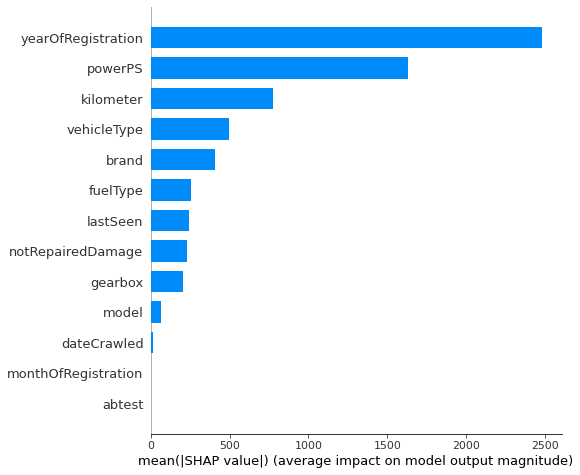

In [182]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")